<a href="https://colab.research.google.com/github/Saguirre9911/Tensroflow_tutoriales/blob/main/Ejemplos%20de%20aplicacion/Tensorflow_Clasificador_de_enfermedades_en_platnas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PAL INGENIERO 2021
## Clasificador de imagenes tensorflow 2.*

Hola a todos, en este nootebook explicaremos como crear una CNN para la clasificación de enfermedades en plantas usando el dataset plant_village que viene con tensorflow


## Canal PAL INGENIERO
https://www.youtube.com/channel/UCTL8_Xr6vzTmCU2h3reHgPw

## Repositorio del notebook



In [1]:
#Librerias a utilizar
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input,Dense,Flatten,Conv2D,MaxPooling2D,Dropout
from tensorflow.keras.models import load_model
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.models import  Sequential, Model
%matplotlib inline

# CARGAR DATASET CON TFDS

In [2]:
ds_train, ds_info = tfds.load(
    'plant_village',#Nombre del set de datos
     split='train', #las opciones pueden variar, algunos tienen solo trainset, otros train, val y test set
      with_info=True, #Guardamos en una variable la información del dataset
      as_supervised=True,#, #generamos el dataset en tuplas, (imagen,etiqueta)
      shuffle_files=True) #Revolvemos el dataset
ds_info
ds_train=ds_train.take(10000)
ds_test_min=ds_train
ds_test=ds_test_min.take(1000)

Shuffling and writing examples to /root/tensorflow_datasets/plant_village/1.0.2.incomplete86PECO/plant_village-train.tfrecord


Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.2. Subsequent calls will reuse this data.


# Procesamiento necesario para utilizar el dataset

In [3]:
def normalizar_datos(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label
BATCH_SIZE=32
#PARA EL SET DE ENTRENAMIENTO
ds_train = ds_train.map(normalizar_datos)# Normalizar los datos, pasa de 0-255 a 0-1
ds_train = ds_train.cache()#Cacheamos el set de datos para que las iteraciones tomen menos tiempo
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)#Se mezclan aleatoriamente, el buffer_size debe ser de la cantidad de datos del dataset para que sea efectivo
ds_train = ds_train.batch(BATCH_SIZE)# agrupamos en lotes de 64 el dataset #IMPORTANTE
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE) #PRECARGAMOS EL DATASET PARA SU USO #MÁS IMPORTANTE, sin esto, no se podrá usar el dataset
#PARA EL SET DE PRUEBA
ds_test= ds_test.map(normalizar_datos)# Normalizar los datos, pasa de 0-255 a 0-1
#ds_test_min=ds_test
ds_test = ds_test.batch(BATCH_SIZE)# agrupamos en lotes de 64 el dataset #IMPORTANTE
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE) #PRECARGAMOS EL DATASET PARA SU USO #MÁS IMPORTANTE, sin esto, no se podrá usar el dataset


## Adquirimos el tamaño de las imagenes para la capa de entrada de la CNN

In [4]:
ds = tfds.load('plant_village', split='train')
ds = ds.take(1)  # tomamos solo un dato

for example in ds:  # example es `{'image': tf.Tensor, 'label': tf.Tensor}`
  print(list(example.keys()))
  image = example["image"]
  input_shape= image.shape
  label = example["label"]
  print(input_shape, label)


['image', 'image/filename', 'label']
(256, 256, 3) tf.Tensor(35, shape=(), dtype=int64)


# Construcción del modelo con Sequential API

### Tutorial PAL INGENIERO
https://www.youtube.com/watch?v=dMHxECuxgyg&list=PLeu9kmTazPwybTtzTe_mBH18BbIELn083 

In [5]:
def get_model(input_shape):
    """
    Creamos una CNN por medio de la API Sequencial, en este link se puede encontrar
    3 tutoriales hechos por nosotros al respecto, donde vemos la creación del modelo
    el método compile y el método fit https://www.youtube.com/watch?v=dMHxECuxgyg&list=PLeu9kmTazPwybTtzTe_mBH18BbIELn083
    
    """

    inputs=Input(shape=input_shape)
    x=Conv2D(32,3,activation='relu',padding='same')(inputs)
    x=Conv2D(32,3,activation='relu',padding='same')(x)
    x=MaxPooling2D(2)(x)
    x=Conv2D(64,3,activation='relu',padding='same')(x)
    x=Conv2D(64,3,activation='relu',padding='same')(x)
    x=MaxPooling2D(2)(x)
    x=Conv2D(128,3,activation='relu',padding='same')(x)
    x=Conv2D(128,3,activation='relu',padding='same')(x)
    x=MaxPooling2D(2)(x)
    x=Flatten()(x)
    x=Dense(128,activation='relu')(x)
    outputs=Dense(38,activation='sigmoid')(x)
    model=Model(inputs=inputs,outputs=outputs)
    rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    model.compile(optimizer=rmsprop, loss= tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
    
    return model
model = get_model(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0     

In [6]:
def train_model(model, train_dataset):
    """
    Entrenamos el modelo con el método fit, en este link se puede encontrar
    3 tutoriales hechos por nosotros al respecto, donde vemos la creación del modelo
    el método compile y el método fit https://www.youtube.com/watch?v=dMHxECuxgyg&list=PLeu9kmTazPwybTtzTe_mBH18BbIELn083
    """
    history = model.fit(train_dataset, epochs=5, batch_size=BATCH_SIZE)
    return history

history = model.fit(ds_train, epochs=10,verbose=2,batch_size=BATCH_SIZE)

Epoch 1/10
313/313 - 63s - loss: 3.4540 - accuracy: 0.2410
Epoch 2/10
313/313 - 47s - loss: 1.6522 - accuracy: 0.5435
Epoch 3/10
313/313 - 47s - loss: 0.8031 - accuracy: 0.7687
Epoch 4/10
313/313 - 47s - loss: 0.3411 - accuracy: 0.8966
Epoch 5/10
313/313 - 47s - loss: 0.1822 - accuracy: 0.9466
Epoch 6/10
313/313 - 47s - loss: 0.1480 - accuracy: 0.9641
Epoch 7/10
313/313 - 47s - loss: 0.1150 - accuracy: 0.9740
Epoch 8/10
313/313 - 47s - loss: 0.1100 - accuracy: 0.9772
Epoch 9/10
313/313 - 47s - loss: 0.0894 - accuracy: 0.9814
Epoch 10/10
313/313 - 47s - loss: 0.1123 - accuracy: 0.9805


## Prueba de funcioanamiento

tf.Tensor(16, shape=(), dtype=int64)
0


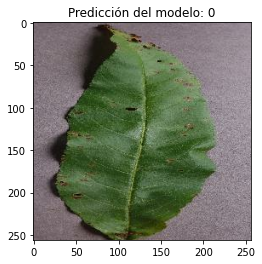

tf.Tensor(27, shape=(), dtype=int64)
27


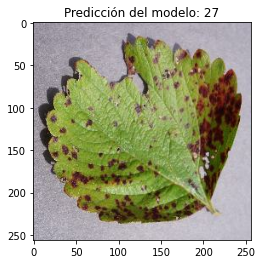

tf.Tensor(24, shape=(), dtype=int64)
24


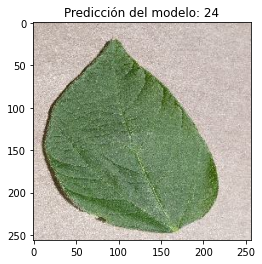

tf.Tensor(0, shape=(), dtype=int64)
0


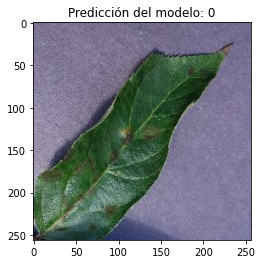

tf.Tensor(37, shape=(), dtype=int64)
33


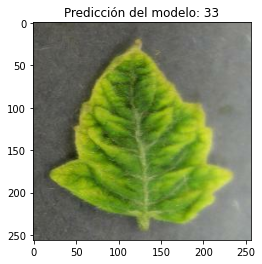

In [7]:
ds_test_min = ds_test_min.take(5)

for example in ds_test_min:  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
  image = example[0]
  label = example[1]
  print( label)
  predictions = model.predict(image[np.newaxis, ...])
  plt.imshow(tf.squeeze(image))
  print(np.argmax(predictions))
  plt.title(f"Predicción del modelo: {np.argmax(predictions)}")
  plt.show()


In [8]:
print(np.argmax(predictions))

33


[Text(0, 0.5, 'Loss'), Text(0.5, 0, 'Epochs')]

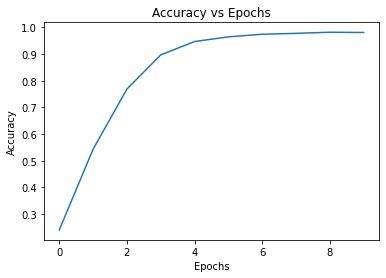

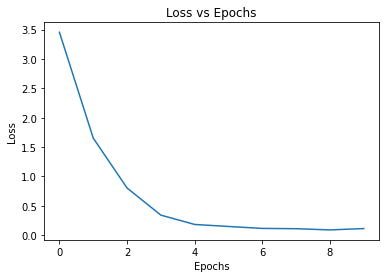

In [9]:
frame = pd.DataFrame(history.history)
acc_plot = frame.plot(y="accuracy", title="Accuracy vs Epochs", legend=False)
acc_plot.set(xlabel="Epochs", ylabel="Accuracy")
acc_plot = frame.plot(y="loss", title = "Loss vs Epochs",legend=False)
acc_plot.set(xlabel="Epochs", ylabel="Loss")



In [10]:
(test_loss, test_accuracy) = model.evaluate(ds_test)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

32/32 [==============================] - 2s 44ms/step - loss: 0.2187 - accuracy: 0.9570
Test loss: 0.21868275105953217
Test accuracy: 0.9570000171661377
